# Анализ набора данных о потреблении электроэнергии и прогнозирование с помощью модели Prophet.

Загрузка библиотек и данных

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

dat = pd.read_csv('/content/Electric_Production.csv')
print(dat.describe())
dat.head(5)

       IPG2211A2N
count  397.000000
mean    88.847218
std     15.387834
min     55.315100
25%     77.105200
50%     89.779500
75%    100.524400
max    129.404800


,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


Prophet требует определенных наименований столбцов, где метки времени должны быть в столбце ds, а целевые значения — в столбце y.

In [27]:
data = pd.read_csv('/content/Electric_Production.csv', encoding='gbk')

data['ds'] = pd.to_datetime(data['DATE'])
data = data.rename(columns={'IPG2211A2N': 'y'})
data['y'] = data['y'].astype(float)
data = data[['ds', 'y']]
print(data.describe())
data.head(5)


                                  ds           y
count                            397  397.000000
mean   2001-07-01 13:25:14.357682560   88.847218
min              1985-01-01 00:00:00   55.315100
25%              1993-04-01 00:00:00   77.105200
50%              2001-07-01 00:00:00   89.779500
75%              2009-10-01 00:00:00  100.524400
max              2018-01-01 00:00:00  129.404800
std                              NaN   15.387834


,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


Визуализируем временной ряд.

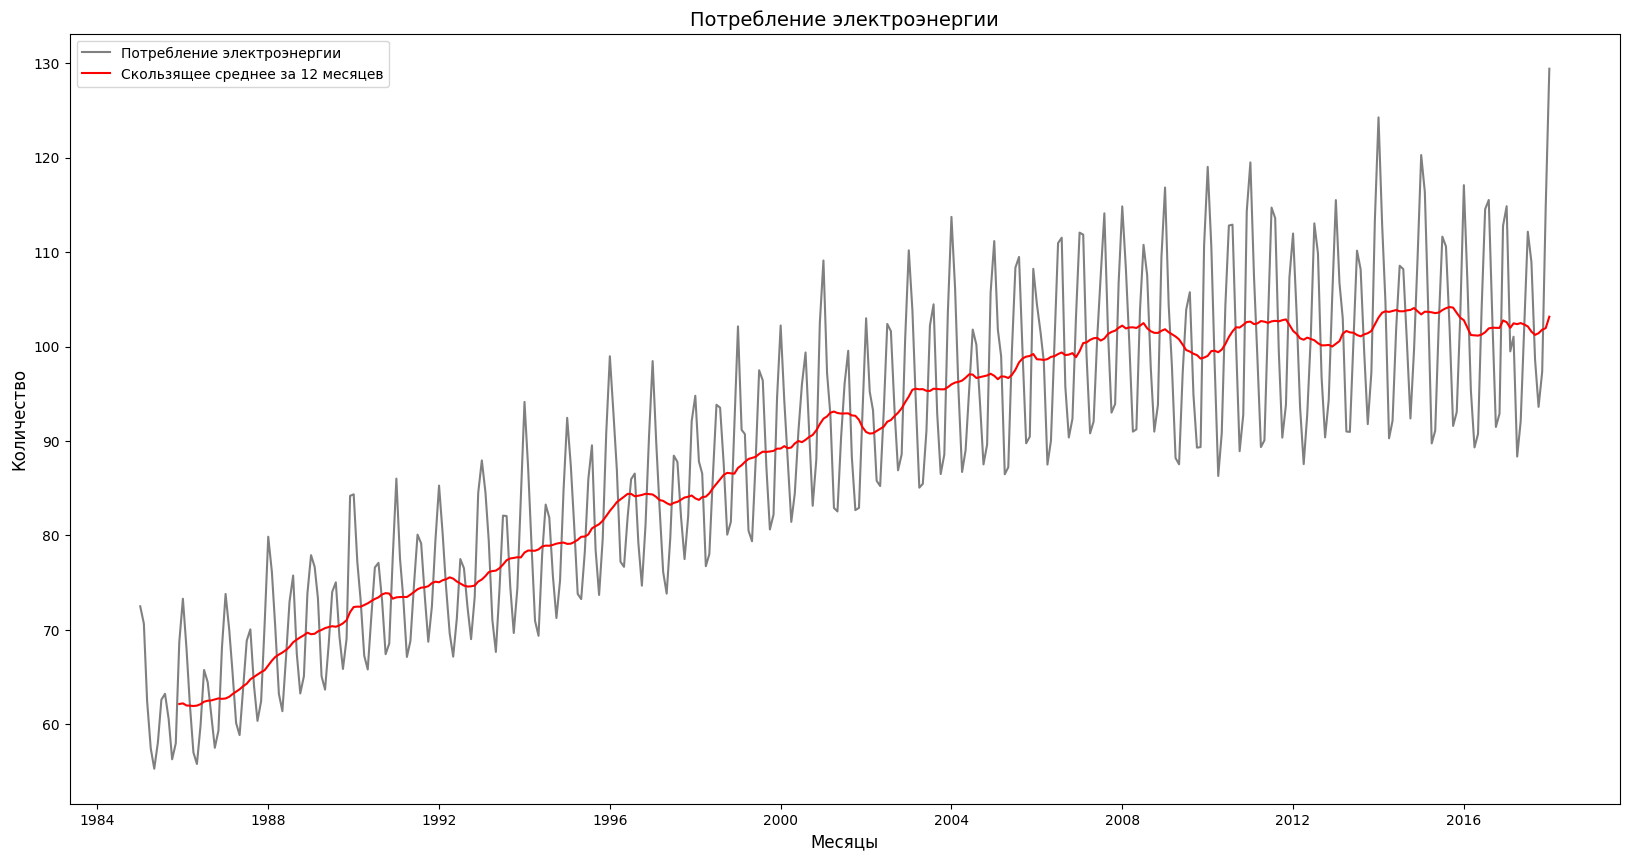

In [28]:
plt.figure(figsize=(20, 10))

data_s = data.set_index('ds')
data_s.head(5)

# зададим кривые
plt.plot(data_s, label = 'Потребление электроэнергии', color = 'gray')
plt.plot(data_s.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'red')
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 10)
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.title('Потребление электроэнергии', fontsize = 14)
plt.show()

Разложим временной ряд на компоненты.

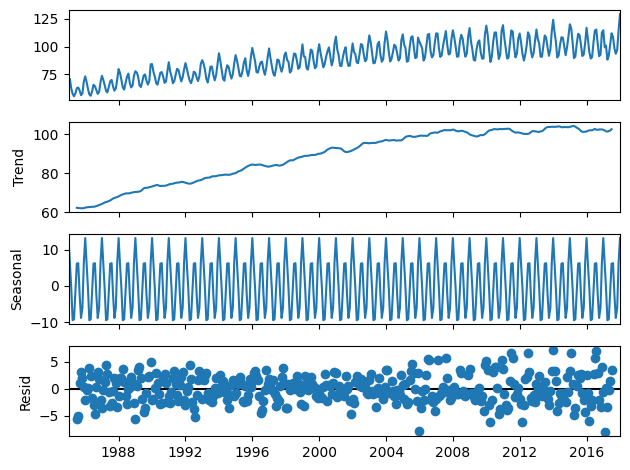

In [29]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# применяем функцию к данным
decompose = seasonal_decompose(data_s)
decompose.plot()
plt.show()

Во временном ряду присутствует нарастающий тренд и сезонность. Проверяем ряд на стационарность по тесту Дики-Фуллера.

In [30]:
# импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(data_s['y'])
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.1862146911658712


Временной ряд нестационарен (p-value > 0.05). Обучим Prophet с использованием стандартных настроек и создадим прогнозы на несколько лет вперед.

In [31]:
prediction = 24
train_df = data[:-prediction].copy()
test_df = data[-prediction:].copy()
test_df.head(-5)

,ds,y
373,2016-02-01,106.6688
374,2016-03-01,95.3548
375,2016-04-01,89.3254
376,2016-05-01,90.7369
377,2016-06-01,104.0375
378,2016-07-01,114.5397
379,2016-08-01,115.5159
380,2016-09-01,102.7637
381,2016-10-01,91.4867
382,2016-11-01,92.8900


In [32]:
#! pip install fbprophet
# импортируем модель prophet и метрики оценки качества
import prophet
from prophet.plot import plot_plotly

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

prophet.diagnostics.logging.disable(level=50)

m = prophet.Prophet()
m.fit(train_df)
# прогноз на 2 года вперед
future = m.make_future_dataframe(periods=24, freq = 'm')
forecast = m.predict(future)

plot_plotly(m, forecast)


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.



In [33]:
v_fb_df = test_df.copy()
v_fb_df['yhat'] = forecast['yhat'].iloc[-24:]
v_fb_df.head(10)

,ds,y,yhat
373,2016-02-01,106.6688,113.056677
374,2016-03-01,95.3548,103.696055
375,2016-04-01,89.3254,93.396559
376,2016-05-01,90.7369,93.218358
377,2016-06-01,104.0375,101.509690
378,2016-07-01,114.5397,109.893165
379,2016-08-01,115.5159,110.984703
380,2016-09-01,102.7637,101.254888
381,2016-10-01,91.4867,94.273465
382,2016-11-01,92.8900,96.849387


Построим график с тестовыми данными и прогнозами модели Prophet.

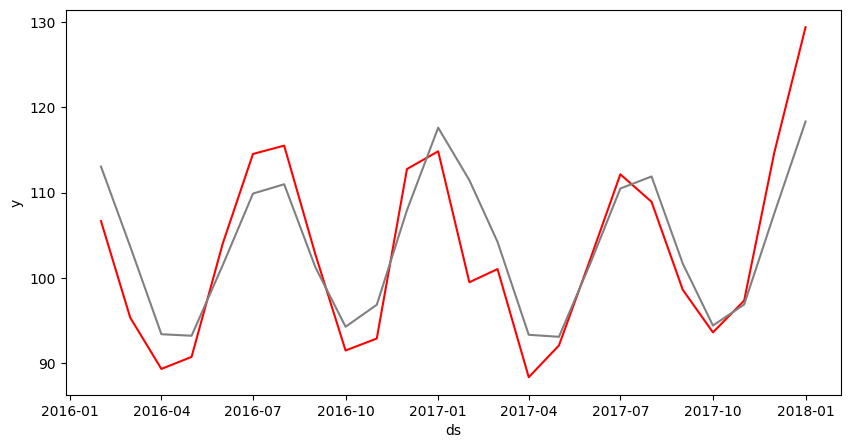

In [34]:
import seaborn as sns

plt.figure(figsize=(10, 5))

sns.lineplot(data=v_fb_df, x='ds', y='y', color = 'red')
sns.lineplot(data=v_fb_df, x='ds', y='yhat', color = 'gray')

plt.show()

Посчитаем метрики качества модели.

In [35]:
np.sqrt(mean_squared_error(v_fb_df['y'], v_fb_df['yhat']))

np.float64(5.053131208756048)

In [36]:
mean_absolute_percentage_error(v_fb_df['y'], v_fb_df['yhat'])

0.03904915147258358